# Analyze 2D Parameter Screen

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook analyzes the responses observed in the parameter screen of two-input network responses.

In [ ]:
import itertools
import math
import numpy as np
import os
import pathlib
import progressbar
import sys

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib import rcParams

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
import ray

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Initialize ray
_ = ray.init(ignore_reinit_error=True)

In [ ]:
# To shut down ray:
ray.shutdown()

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [ ]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.2
matplotlib=3.5.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Categorize Responses into Unique Functions ("Voxels")

### Define Functions

In [8]:
@ray.remote
def ray_digitize(S_all_filtered_processed,boundaries):
    return np.digitize(S_all_filtered_processed,boundaries)

In [12]:
def calculate_unique_voxels(S_all_filtered_processed,boundaries,return_inverse=False,curves_per_chunk=5000):
    '''
    Given curves, categorize them into unique functions ("voxels") by binning the output at each input point.

    Uses np.digitize and ray for parallelization.
    
    Parameters:
    ----------
    S_all_filtered_processed: 2D array of shape (n_curves, t)
        Array of all responses
    boundaries: 1D array
        Array of boundaries at which to split output space.
    curves_per_chunk: Int
        Number of curves to consider at once.
    return_inverse: Bool
        Whether to return unique_inverse, a map of which curve went into which unique voxel.
        
    Returns:
    --------
    unique_voxels: 2D array of shape (n_unique_voxels, t)
        Array of all unique voxels found
    unique_inverse: 1D array of shape (n_curves,)
        Array describing, for each curve in the original dataset, which voxel in 
        unique_voxels it was assigned to.
    '''
    n_digitize_chunks = math.ceil(S_all_filtered_processed.shape[0]/curves_per_chunk)
    voxels = np.empty(S_all_filtered_processed.shape)
    digitize_futures = []
    for chunk in range(n_digitize_chunks):
        digitize_futures.append(ray_digitize.remote(S_all_filtered_processed[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk,:],\
                                boundaries))
    for chunk in range(n_digitize_chunks):
        voxels[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk,:] = ray.get(digitize_futures[chunk])
    return np.unique(voxels,axis=0,return_inverse=return_inverse)

In [11]:
def calculate_voxel_overlap(unique_voxels_1, unique_voxels_2):
    '''
    Given two sets of unique functions, calculate the number of functions common to both sets.
    '''
    n1 = unique_voxels_1.shape[0]
    n2 = unique_voxels_2.shape[0]
    unique_voxels_joint = np.unique(np.concatenate((unique_voxels_1,unique_voxels_2),axis=0),axis=0,return_inverse=False)
    n_joint = unique_voxels_joint.shape[0]
    return n1+n2-n_joint

### Unique Functions by Network Size - Figure 4A, S3

This section performs the initial categorization of response functions; subsequent sections will draw from the saved files.

In [13]:
input_lb = -3 # Lower bound of input space in log scale
input_ub = 3 # Upper bound of input space in log scale
t = 30 # Number of input points
t_voxels = 6 # Number of input points to use for voxel calculation (e.g., 5 input points grouped in each voxel)

min_affinity=1e-5 # Affinity threshold for considering a dimer to be possible

In [14]:
# Directory to load data from
load_dir = '/home/ubuntu/Data/20230113_2input_randomParamset'

In [15]:
# Network sizes to test
m_list = list(range(2,13))

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
num_unfiltered_curves_by_m = [np.sum(unfiltered_curves_per_Sall_chunk_by_m[m_i]) for m_i, m in enumerate(m_list)]
num_nonzero_curves_by_m = [np.sum(nonzero_curves_per_Sall_chunk_by_m[m_i]) for m_i, m in enumerate(m_list)]
num_filtered_curves_by_m = [np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]) for m_i, m in enumerate(m_list)]

In [ ]:
fraction_passed_filtering_by_m = np.divide(num_filtered_curves_by_m,num_unfiltered_curves_by_m)
fraction_nonzero = np.divide(num_nonzero_curves_by_m,num_unfiltered_curves_by_m)
fraction_nonzero_constant = np.divide(np.array(num_nonzero_curves_by_m)-np.array(num_filtered_curves_by_m),num_unfiltered_curves_by_m)

In [ ]:
# Define voxels
num_regions_per_inputpoint = 6 # Split output space into this many bins at each input point
boundaries = np.logspace(input_lb,input_ub,num_regions_per_inputpoint+1,endpoint=True)[1:-1]

In [ ]:
num_unique_voxels_by_m = []

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    S_all_filenames = S_all_filenames_by_m[m_i]
    num_S_all_chunks = len(S_all_filenames)
    # Iterate over chunks of S_all (the responses), which were saved across several files
    for S_all_chunk in range(num_S_all_chunks):
        # Load:
        S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        # Average into voxels
        S_all_processed_filtered_reshaped = S_all_processed_filtered.reshape((-1,t,t))
        S_all_processed_filtered_reshaped_averaged = np.empty((S_all_processed_filtered.shape[0],t_voxels,t_voxels))
        points_to_average = int(t//t_voxels)
        if t%t_voxels!=0:
            print("t_voxels must be integer factor of t")
        for input1 in range(t_voxels):
            for input2 in range(t_voxels):
                S_all_processed_filtered_reshaped_averaged[:,input1,input2] = 10**np.mean(np.log10(S_all_processed_filtered_reshaped[:,\
                                                                                (input1*points_to_average):(input1*points_to_average)+points_to_average,\
                                                                                (input2*points_to_average):(input2*points_to_average)+points_to_average]),axis=(1,2))
        S_all_processed_filtered_averaged = S_all_processed_filtered_reshaped_averaged.reshape((-1,t_voxels**2))
        if S_all_chunk==0:
            unique_voxels,unique_inverse = calculate_unique_voxels(S_all_processed_filtered_averaged,boundaries,t=t_voxels**2,return_inverse=True)
        else:
            # Get unique voxels and map for this chunk
            unique_voxels_temp,unique_inverse_temp = calculate_unique_voxels(S_all_processed_filtered_averaged,boundaries,t=t_voxels**2,return_inverse=True)
            # Then calculate the unique voxels on the whole set
            meta_unique_voxels,meta_unique_inverse = np.unique(np.concatenate((unique_voxels,unique_voxels_temp),\
                                                     axis=0),axis=0,return_inverse=True)
            # Create a map describing how the unique voxels changed from the two subsets to the superset
            meta_unique_inverse_map = dict(np.concatenate((np.expand_dims(np.arange(meta_unique_inverse.shape[0]),axis=1),np.expand_dims(meta_unique_inverse,axis=1)),axis=1))
            # Translate the unique_inverse files into new, meta-clustered indices
            unique_inverse2 = np.vectorize(meta_unique_inverse_map.get)(unique_inverse)
            unique_inverse_temp2 = np.vectorize(meta_unique_inverse_map.get)(unique_inverse_temp+unique_voxels.shape[0])
            # Recreate objects after meta-clustering
            unique_voxels = meta_unique_voxels
            unique_inverse = np.concatenate((unique_inverse2,unique_inverse_temp2),axis=0)
    if num_S_all_chunks>1:
        del unique_voxels_temp,unique_inverse_temp,meta_unique_voxels,meta_unique_inverse,unique_inverse2, unique_inverse_temp2
    n_unique_voxels = unique_voxels.shape[0]
    num_unique_voxels_by_m.append(unique_voxels.shape[0])
    np.save(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),unique_voxels)
    print("Calculating Voxel Averages")
    # clustered_responses = [np.empty((0,t)) for x in range(n_unique_voxels)]
    curves_by_voxel = []
    voxel_averages = np.zeros((n_unique_voxels,t**2))
    num_curves_per_voxel = np.zeros((n_unique_voxels,))
    for unique_voxel in range(n_unique_voxels):
        # Create curves_by_voxel array to map curves to voxels
        curves_by_voxel.append(np.where(unique_inverse==unique_voxel)[0])
    # For each voxel, calculate the average response in log space (need to iterate over S_all chunks)
    for S_all_chunk in range(num_S_all_chunks):
        S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        for unique_voxel in range(n_unique_voxels):
            curves_by_voxel_this_chunk = curves_by_voxel[unique_voxel][np.where((curves_by_voxel[unique_voxel]>=np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                     & (curves_by_voxel[unique_voxel]<np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))]
            curves_by_voxel_this_chunk = (curves_by_voxel_this_chunk-np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)
            clustered_responses_temp = S_all_processed_filtered[curves_by_voxel_this_chunk,:]
            if clustered_responses_temp.shape[0]==0:
                continue
            # clustered_responses[unique_voxel] = np.append(clustered_responses[unique_voxel],clustered_responses_temp,axis=0)
            # Take average in log space
            if np.all(voxel_averages[unique_voxel,:]==0):
                voxel_averages[unique_voxel,:] = np.expand_dims(10**np.mean(np.log10(clustered_responses_temp),axis=0),axis=0)
            else:
                # If there were some responses from prior voxels, take a weighted average with those
                voxel_averages[unique_voxel,:] = 10**np.average(np.concatenate((np.expand_dims(np.log10(voxel_averages[unique_voxel,:]),axis=0),\
                                                                           np.expand_dims(np.mean(np.log10(clustered_responses_temp),axis=0),axis=0)),axis=0),\
                                                                           weights = np.array([num_curves_per_voxel[unique_voxel],clustered_responses_temp.shape[0]]),\
                                                                           axis=0)
            num_curves_per_voxel[unique_voxel]+=clustered_responses_temp.shape[0]
    np.save(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),curves_by_voxel)
    np.save(str(pathlib.Path(out_dir,f'{m}M_voxel_averages.npy')),voxel_averages)

In [ ]:
np.save(str(pathlib.Path(out_dir,f'num_unique_voxels_by_m.npy')),num_unique_voxels_by_m)

In [ ]:
num_unique_voxels_by_m = np.load(str(pathlib.Path(out_dir,f'num_unique_voxels_by_m.npy')),allow_pickle=True)

Now create the relevant plots:

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,num_unique_voxels_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title('Overall Expressivity by Network Size')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])


filename = f'num_unique_voxels_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,[num_unique_voxels_by_m[m_i]/num_unfiltered_curves_by_m[m_i]\
               for m_i in range(len(m_list))],width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Dimers')
_ = ax.set_title('Overall Expressivity by Network Size\n(Normalized to # Dimers)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_unique_voxels_by_network_size_unfilt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,[num_unique_voxels_by_m[m_i]/num_filtered_curves_by_m[m_i]\
               for m_i in range(len(m_list))],width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Filtered Responses')
_ = ax.set_title('Overall Expressivity by Network Size\n(Normalized to # Filtered Responses)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_unique_voxels_by_network_size_filt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,[num_filtered_curves_by_m[m_i]/num_unique_voxels_by_m[m_i]\
               for m_i in range(len(m_list))],width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Filtered Responses /\nNumber of Unique Discretized Functions')
_ = ax.set_title('Function Redundancy by Network Size')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'redundancy_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,fraction_passed_filtering_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Nonzero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'fraction_passed_filter_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,fraction_nonzero,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Dimers Formed at Significant Concentrations')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])
_ = ax.set_ylim([0,1])

filename = f'fraction_nonzero_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,fraction_nonzero_constant,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Dimers Formed but Unresponsive to Input')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])
_ = ax.set_ylim([0,1])

filename = f'fraction_nonzero_constant_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,num_unfiltered_curves_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unfiltered Responses')
_ = ax.set_title('Total Number of Dimers Analyzed')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_unfiltered_curves_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,num_filtered_curves_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Filtered Responses')
_ = ax.set_title('Total Number of Non-zero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_filtered_curves_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

And now calculate overlaps in the expressivity of different network sizes:

In [ ]:
voxel_overlaps = np.zeros((len(m_list),len(m_list)))
voxel_overlap_fractions = np.zeros((len(m_list),len(m_list)))

num_unique_voxels_by_m = np.zeros((len(m_list),))

for m_i_1, m_1 in enumerate(m_list):
    unique_voxels_1 = np.load(str(pathlib.Path(out_dir,f'{m_1}M_unique_voxels.npy')),allow_pickle=True)
    num_unique_voxels_by_m[m_i_1] = unique_voxels_1.shape[0]
    for m_i_2, m_2 in enumerate(m_list):
        unique_voxels_2 = np.load(str(pathlib.Path(out_dir,f'{m_2}M_unique_voxels.npy')),allow_pickle=True)
        voxel_overlaps[m_i_1,m_i_2] = calculate_voxel_overlap(unique_voxels_1, unique_voxels_2)
        voxel_overlaps[m_i_2,m_i_1] = voxel_overlaps[m_i_1,m_i_2]
for m_i_1, m_1 in enumerate(m_list):
    for m_i_2, m_2 in enumerate(m_list):
        # Calculate overlap as fraction of 1
        voxel_overlap_fractions[m_i_1,m_i_2] = \
                voxel_overlaps[m_i_1,m_i_2]/num_unique_voxels_by_m[m_i_1]

np.save(str(pathlib.Path(out_dir,f'network_size_voxel_overlaps.npy')),voxel_overlaps)
np.save(str(pathlib.Path(out_dir,f'network_size_voxel_overlap_fractions.npy')),voxel_overlap_fractions)

In [ ]:
voxel_overlaps = np.load(str(pathlib.Path(out_dir,f'network_size_voxel_overlaps.npy')),allow_pickle=True)
voxel_overlap_fractions = np.load(str(pathlib.Path(out_dir,f'network_size_voxel_overlap_fractions.npy')),allow_pickle=True)

And plot:

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

cmap = cm.get_cmap('RdBu').copy()

vmin = 0.05*(np.min(voxel_overlap_fractions)//0.05)
vmax = 1
matrix = ax.matshow(voxel_overlap_fractions,cmap = cmap,vmin=vmin,vmax=vmax)

for (j,i),label in np.ndenumerate(voxel_overlap_fractions):
    if label>(vmin+(0.2*(vmax-vmin))) and label<(vmin+(0.8*(vmax-vmin))):
        color='black'
    else:
        color='white'
    ax.text(i,j,round(label,2),ha='center',va='center',fontsize=8,color=color)

labels = [f'm={m}' for m in m_list]

ax.set_xticks(list(range(len(m_list))))
ax.set_xticklabels(labels,fontsize=10,rotation=90)
ax.xaxis.set_ticks_position("bottom")

ax.set_yticks(list(range(len(m_list))))
ax.set_yticklabels(labels,fontsize=10)

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False
 )
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.top.set_visible(False)

fig.colorbar(matrix, ax=ax,label='Fraction of #1 represented in #2')

_ = ax.set_xlabel('Network Size #2')
_ = ax.set_ylabel('Network Size #1')
_ = ax.set_title(f'Function Overlaps Among Different Network Sizes',fontsize=14)

filename = f'network_size_voxel_overlaps'
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Distribution of Function Prevalence - Figure S3

"Distribution of prevalence" asks, for a given unique function, how many random responses were categorized as performing that function

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze
t = 30 # Number of input points
t_voxels = 6 # Number of input regions for voxel categorization

In [ ]:
S_all_filenames_by_m = np.load(str(pathlib.Path(out_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(out_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(out_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

We are going to calculate voxel prevalence not only within each network size (m), but across the whole dataset as well

In [ ]:
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    # Load data on voxels
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    voxel_averages = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_averages.npy')),allow_pickle=True)
    # Calculate number of curves per voxel, within this network size
    num_curves_by_voxel = np.array([x.shape[0] for x in curves_by_voxel])
    num_curves_by_voxel_sorted = np.sort(num_curves_by_voxel)[::-1].astype(np.int64)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_curves_by_voxel_sorted.npy')),num_curves_by_voxel_sorted)
    if m_i ==0:
        # If first network size, initialize meta-variables
        new_meta_unique_voxels = unique_voxels.copy()
        new_meta_voxel_averages = voxel_averages.copy()
        new_num_curves_by_meta_voxel = np.array([x.shape[0] for x in curves_by_voxel])
    else:
        # Calculate unique voxels across whole dataset of network sizes
        new_meta_unique_voxels, new_meta_unique_inverse = np.unique(np.concatenate((meta_unique_voxels,unique_voxels),axis=0),axis=0,return_inverse=True)
        # Recalculate number of curves per voxel, across whole dataset of network sizes
        num_curves_by_meta_voxel = np.concatenate((num_curves_by_meta_voxel,np.zeros((new_meta_unique_voxels.shape[0]-meta_unique_voxels.shape[0]))))
        new_num_curves_by_meta_voxel = np.zeros((new_meta_unique_voxels.shape[0],))
        new_meta_voxel_averages = np.empty((new_meta_unique_voxels.shape[0],t))
        for old_voxel in range(meta_unique_voxels.shape[0]):
            #  If voxel was previously in dataset, append to old values
            corresponding_meta_voxel = new_meta_unique_inverse[old_voxel]
            new_num_curves_by_meta_voxel[corresponding_meta_voxel] += num_curves_by_meta_voxel[old_voxel]
            new_meta_voxel_averages[corresponding_meta_voxel,:] = meta_voxel_averages[old_voxel,:]
        for new_voxel in range(unique_voxels.shape[0]):
            #  If voxel is new, calculate new values
            num_new_curves = curves_by_voxel[new_voxel].shape[0]
            corresponding_meta_voxel = new_meta_unique_inverse[new_voxel+meta_unique_voxels.shape[0]]
            if np.where(new_meta_unique_inverse==corresponding_meta_voxel)[0].shape[0]==1:
                new_meta_voxel_averages[corresponding_meta_voxel,:] = voxel_averages[new_voxel,:]
            else:
                new_meta_voxel_averages[corresponding_meta_voxel,:] = 10**np.average(\
                        np.log10(np.vstack((new_meta_voxel_averages[corresponding_meta_voxel,:],\
                                        voxel_averages[new_voxel]))),axis=0,weights=\
                            np.array([new_num_curves_by_meta_voxel[corresponding_meta_voxel],\
                                     num_new_curves]))
            new_num_curves_by_meta_voxel[corresponding_meta_voxel] += num_new_curves
        
    meta_unique_voxels = new_meta_unique_voxels.copy()
    meta_voxel_averages = new_meta_voxel_averages.copy()
    num_curves_by_meta_voxel = new_num_curves_by_meta_voxel.copy()

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


In [ ]:
# Sort meta voxels by number of curves
num_curves_by_meta_voxel_sorted = np.sort(num_curves_by_meta_voxel)[::-1].astype(np.int64)
total_num_unique_voxels = meta_unique_voxels.shape[0]

In [ ]:
np.save(str(pathlib.Path(out_dir,f'num_curves_by_meta_voxel_sorted.npy')),num_curves_by_meta_voxel_sorted)

In [ ]:
num_curves_by_meta_voxel_sorted = np.load(str(pathlib.Path(out_dir,f'num_curves_by_meta_voxel_sorted.npy')),allow_pickle=True)

Plot overall:

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(list(range(num_curves_by_meta_voxel_sorted.shape[0])),num_curves_by_meta_voxel_sorted,linewidth=2,color='k')
ax.fill_between(list(range(num_curves_by_meta_voxel_sorted.shape[0])),num_curves_by_meta_voxel_sorted,color='darkgray')

_ = ax.set_xlabel(f'Unique Discretized Functions (Rank-ordered)')
_ = ax.set_ylabel('Log (Number of Responses Performing Function)')
_ = ax.set_title('Distribution of Responses Among Unique Functions')

ax.set_yscale('log')

filename = f'voxel_size_distribution'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('hsv')

for m in reversed(m_list):
    m_i = m_list.index(m)
    num_curves_by_voxel_sorted = np.load(str(pathlib.Path(out_dir,f'{m}M_num_curves_by_voxel_sorted.npy')),allow_pickle=True)
    ax.plot(list(range(num_curves_by_voxel_sorted.shape[0])),num_curves_by_voxel_sorted,linewidth=2,color=cmap(m_i/len(m_list)))

_ = ax.set_xlabel(f'Unique Discretized Functions (Rank-ordered)')
_ = ax.set_ylabel('Log (Number of Responses Performing Function)')
_ = ax.set_title('Distribution of Responses Among Unique Functions')

ax.set_yscale('log')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'voxel_size_distribution_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('hsv')

for m in reversed(m_list):
    m_i = m_list.index(m)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    total_num_curves = np.sum([x.shape[0] for x in curves_by_voxel])
    num_curves_by_voxel_sorted = np.load(str(pathlib.Path(out_dir,f'{m}M_num_curves_by_voxel_sorted.npy')),allow_pickle=True)
    ax.plot(list(range(num_curves_by_voxel_sorted.shape[0])),[x/total_num_curves for x in num_curves_by_voxel_sorted],\
            linewidth=2,color=cmap(m_i/len(m_list)))

_ = ax.set_xlabel(f'Unique Discretized Functions (Rank-ordered)')
_ = ax.set_ylabel('Log (Fraction of Responses Performing Function)')
_ = ax.set_title('Normalized Distribution of Responses Among Unique Functions')

ax.set_yscale('log')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'voxel_size_distribution_by_network_size_norm'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Number of Unique Functions by Dimer Type - Figure S3

Here, we break down expressivity by "dimer type," i.e., input-accessory heterodimers, accessory homodimers, etc.

We will not re-calculate the voxels, but rather just analyze the existing dataset from the network size analysis

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
# Define voxels
num_regions_per_inputpoint = 6

boundaries = np.logspace(input_lb,input_ub,num_regions_per_inputpoint+1,endpoint=True)[1:-1]

In [ ]:
num_unique_voxels_by_species_type_by_m = [[] for x in range(4)]
num_filtered_curves_by_species_type_by_m = [[] for x in range(4)]
num_unfiltered_curves_by_species_type_by_m = [[] for x in range(4)]
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    # Load info on dataset
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    # Create unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    num_sets = param_sets.shape[0]
    num_possible_num_edges = num_combos(m,r=2) - (m-1) + 1
    num_sets_per_num_edges = math.ceil(num_sets/num_possible_num_edges)

    # Calculate dimer types
    input_input_homodimer = []
    input_acc_heterodimers = []
    acc_acc_homodimers = []
    acc_acc_heterodimers = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            if combo[0]==0:
                input_input_homodimer.append(i)
            else:
                acc_acc_homodimers.append(i)
        else:
            if combo[0]==0 or combo[1]==0:
                input_acc_heterodimers.append(i)
            else:
                acc_acc_heterodimers.append(i)

    species_types = [input_input_homodimer,input_acc_heterodimers,acc_acc_homodimers,acc_acc_heterodimers]
    species_per_network = num_combos_with_replacement(m,r=2)
    num_S_all_chunks = len(S_all_filenames_by_m[m_i])
    unique_voxel_ids_by_species_type = []
    for species_type_i in range(4):
        # Identify curve indices for this species type
        num_curves_this_species_type = num_sets*len(species_types[species_type_i])
        curve_idx_this_species_type = np.zeros((num_curves_this_species_type,),dtype=np.int64)
        for species_i, species in enumerate(species_types[species_type_i]):
            curve_idx_this_species_type[np.linspace(0,num_curves_this_species_type,num_sets,endpoint=False,dtype=np.int64)+species_i]=\
                np.linspace(0,num_sets*species_per_network,num_sets,endpoint=False,dtype=np.int64)+species # Unfiltered IDs
        num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_this_species_type])
        num_filtered_ids = 0
        unique_voxel_ids = np.empty((0,))
        # Iterate over chunks of S_all (the responses), which were saved across several files
        for S_all_chunk in range(num_S_all_chunks):
            # Find curve indices of this species type in this chunk
            curve_idx_this_species_type_in_chunk = curve_idx_this_species_type[np.where((curve_idx_this_species_type>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_this_species_type<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs in chunk
            if curve_idx_this_species_type_in_chunk.shape[0]==0:
                continue
            # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
            curve_idx_this_species_type_in_chunk = (curve_idx_this_species_type_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs in chunk, starting at 0 in chunk
            curve_idx_this_species_type_passed_filter = \
                curve_idx_this_species_type_in_chunk[np.isin(curve_idx_this_species_type_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs in chunk, starting at 0 in chunk, that passed filtering
            curve_idx_this_species_type_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_this_species_type_passed_filter)][:,1] # Filtered IDs in chunk, starting at 0 in chunk
            num_filtered_ids += curve_idx_this_species_type_filtered.shape[0]
            # S_all_subset = S_all_processed_filtered[curve_idx_this_species_type_filtered,:]
            # Knowing all the voxels for this subset of the data, calculate the unique indices of those voxels
            if unique_voxel_ids.shape[0]==0:
                # If first S_all chunk with any curves of this species type, initialize unique_voxel_ids
                unique_voxel_ids = np.unique(unique_inverse[(curve_idx_this_species_type_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
            else:
                # Otherwise, append to unique_voxel_ids
                unique_voxel_ids_temp = np.unique(unique_inverse[(curve_idx_this_species_type_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                         axis=0),axis=0,return_inverse=False)
        unique_voxel_ids_by_species_type.append(unique_voxel_ids)
        if num_filtered_ids==0:
            num_unique_voxels_by_species_type_by_m[species_type_i].append(0)
            num_unfiltered_curves_by_species_type_by_m[species_type_i].append(num_unfiltered_ids)
            num_filtered_curves_by_species_type_by_m[species_type_i].append(num_filtered_ids)
        else:
            num_unique_voxels_by_species_type_by_m[species_type_i].append(unique_voxel_ids.shape[0])
            num_unfiltered_curves_by_species_type_by_m[species_type_i].append(num_unfiltered_ids)
            num_filtered_curves_by_species_type_by_m[species_type_i].append(num_filtered_ids)
        
    voxel_overlaps = np.zeros((4,4))
    voxel_overlap_fractions = np.zeros((4,4))

    # Calculate function overlaps between species types
    for species_type_i_1 in range(4):
        unique_voxel_ids_1 = unique_voxel_ids_by_species_type[species_type_i_1]
        for species_type_i_2 in range(4):
            unique_voxel_ids_2 = unique_voxel_ids_by_species_type[species_type_i_2]
            voxel_overlaps[species_type_i_1,species_type_i_2] = calculate_voxel_overlap(unique_voxel_ids_1, unique_voxel_ids_2)
            voxel_overlaps[species_type_i_2,species_type_i_1] = voxel_overlaps[species_type_i_1,species_type_i_2]
    for species_type_i_1 in range(4):
        for species_type_i_2 in range(4):
            # Calculate overlap as fraction of K_i_1
            voxel_overlap_fractions[species_type_i_1,species_type_i_2] = \
                    voxel_overlaps[species_type_i_1,species_type_i_2]/unique_voxel_ids_by_species_type[species_type_i_1].shape[0]

    np.save(str(pathlib.Path(out_dir,f'{m}M_voxel_overlaps_by_species_type.npy')),voxel_overlaps)
    np.save(str(pathlib.Path(out_dir,f'{m}M_voxel_overlap_fractions_by_species_type.npy')),voxel_overlap_fractions)

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


In [ ]:
fraction_passed_filter_by_species_type_by_m = [[num_filtered_curves_by_species_type_by_m[species_type_i][m_i]/\
                                                num_unfiltered_curves_by_species_type_by_m[species_type_i][m_i]\
                                               for m_i, m in enumerate(m_list)] \
                                               for species_type_i in range(4)]

In [ ]:
np.save(str(pathlib.Path(out_dir,f'num_unique_voxels_by_species_type_by_m.npy')),num_unique_voxels_by_species_type_by_m)
np.save(str(pathlib.Path(out_dir,f'num_unfiltered_curves_by_species_type_by_m.npy')),num_unfiltered_curves_by_species_type_by_m)
np.save(str(pathlib.Path(out_dir,f'num_filtered_curves_by_species_type_by_m.npy')),num_filtered_curves_by_species_type_by_m)
np.save(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_species_type_by_m.npy')),fraction_passed_filter_by_species_type_by_m)

In [ ]:
num_unique_voxels_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'num_unique_voxels_by_species_type_by_m.npy')),allow_pickle=True)
num_unfiltered_curves_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'num_unfiltered_curves_by_species_type_by_m.npy')),allow_pickle=True)
num_filtered_curves_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'num_filtered_curves_by_species_type_by_m.npy')),allow_pickle=True)
fraction_passed_filter_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_species_type_by_m.npy')),allow_pickle=True)

Plot:

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,num_unique_voxels_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Expressivity by Species Type')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,np.divide(num_unique_voxels_by_species_type_by_m[species_type_i],num_unfiltered_curves_by_species_type_by_m[species_type_i]),\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Dimers')
_ = ax.set_title(f'Expressivity by Species Type\n(Normalized to # Unfiltered Responses)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_species_type_unfilt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,np.divide(num_unique_voxels_by_species_type_by_m[species_type_i],num_filtered_curves_by_species_type_by_m[species_type_i]),\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Filtered Responses')
_ = ax.set_title(f'Expressivity by Species Type\n(Normalized to # Filtered Responses)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_species_type_filt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,np.divide(num_filtered_curves_by_species_type_by_m[species_type_i],num_unique_voxels_by_species_type_by_m[species_type_i]),\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Filtered Responses /\n Number of Unique Discretized Functions')
_ = ax.set_title(f'Function Redundancy by Species Type')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'redundancy_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,fraction_passed_filter_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Nonzero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,num_unfiltered_curves_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unfiltered Responses')
_ = ax.set_title(f'Total Number of Dimers Analyzed')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unfiltered_curves_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,num_filtered_curves_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Filtered Responses')
_ = ax.set_title(f'Total Number of Non-zero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_filtered_curves_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

And, for each network size, plot overlaps in the unique functions different species types can compute

In [ ]:
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    voxel_overlaps = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_overlaps_by_species_type.npy')),allow_pickle=True)
    voxel_overlap_fractions = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_overlap_fractions_by_species_type.npy')),allow_pickle=True)
    fig, ax = plt.subplots(figsize=(12,6))

    cmap = cm.get_cmap('RdBu').copy()

    vmin = 0.5
    vmax = 1
    matrix = ax.matshow(voxel_overlap_fractions,cmap = cmap,vmin=vmin,vmax=vmax)

    for (j,i),label in np.ndenumerate(voxel_overlap_fractions):
        if label>(vmin+(0.2*(vmax-vmin))) and label<(vmin+(0.8*(vmax-vmin))):
            color='black'
        else:
            color='white'
        ax.text(i,j,round(label,2),ha='center',va='center',fontsize=8,color=color)

    spacer = ' '*10
    labels = ['Input-Input Homodimer','Input-Accessory Heterodimers','Accessory Homodimers','Accessory-Accessory Heterodimers']

    ax.set_xticks(list(range(4)))
    ax.set_xticklabels(labels,fontsize=8,rotation=90)
    ax.xaxis.set_ticks_position("bottom")

    ax.set_yticks(list(range(4)))
    ax.set_yticklabels(labels,fontsize=8)

    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        right=False,
        left=False
     )
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)

    fig.colorbar(matrix, ax=ax,label='Fraction of #1 represented in #2')

    _ = ax.set_xlabel('Species Type #2')
    _ = ax.set_ylabel('Species Type #1')
    _ = ax.set_title(f'Cluster Overlaps Among Different Species Types (m={m})',fontsize=14)
    
    filename = f'{m}M_voxel_overlaps_by_species_type'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Number of Unique Functions by Network Connectivity - Figure 4, S3

In [ ]:
load_dir = '/home/ubuntu/Data/20230113_2input_randomParamset'

In [ ]:
m_list = list(range(2,13))

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

# Function to count the number of edges in a parameter set
def count_edges(param_set):
    return np.where(param_set>=min_affinity)[0].shape[0]

In [ ]:
# Different network connectivities were sampled evenly within each network size, but across network sizes they were sampled differently
# This is because each network size got 1 million networks - while m=3 only has two connectivity levels, m=12 has many more, and each gets fewer networks
# So we just have to find the minimum and will bootstrap this number of networks
num_sets_per_num_edges_by_m = []
for m_i,m in enumerate(m_list):
    print(f"Processing m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m-1
    num_possible_num_edges = max_hetero_edges-min_hetero_edges+1 # number of possible connectivity values
    num_sets_per_num_edges = math.ceil(param_sets.shape[0]/num_possible_num_edges) # How many parameter sets were simulated for each connectivity value
    num_sets_per_num_edges_by_m.append(num_sets_per_num_edges)
np.save(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),num_sets_per_num_edges_by_m)

In [ ]:
num_sets_per_num_edges_by_m = np.load(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),allow_pickle=True)

In [ ]:
# Calculate number of networks to bootstrap from each network size to ensure comparable number of networks per network size & connectivity
min_sets_per_num_edges = np.min(num_sets_per_num_edges_by_m)
num_bootstrap_samples = 5
rng = np.random.default_rng()

In [ ]:
for m_i,m in enumerate(m_list):
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    num_possible_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    # Calculate unique_inverse, which maps each curve to its voxel
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    # Compute types of edges (heterodimer, homodimer)
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)

    # Calculate how many heterodimer edges each parameter set has
    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    
    num_unique_voxels_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    redundancy_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    unfiltered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    filtered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]

    fraction_passed_filter_by_hetero_edges = []
    total_unfiltered_curves_by_hetero_edges = []
    total_filtered_curves_by_hetero_edges = []
    
    # If we are analyzing the largest network, we need only bootstrap once because we are using the full dataset
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    
    # Iterate over number of heterodimer edges
    for num_hetero_edges_i,num_hetero_edges in enumerate(hetero_edges_list):
        # Identify parameter sets with this number of heterodimer edges
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # To sample evenly, we will then bootstrap from this list of parameter sets
        for bootstrap_i in range(num_bootstrap_samples_temp):
            # Randomly bootstrap from the list of parameter sets with this number of heterodimer edges
            param_set_idx_with_num_edges_bootstrap = rng.choice(param_set_idx_with_num_edges,size=(min_sets_per_num_edges,),replace=False)
            curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                        (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges_bootstrap]))) # Unfiltered IDs
            num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_with_num_edges])
            num_filtered_ids = 0
            unique_voxel_ids = np.empty((0,))
            # Iterate over chunks of S_all (the responses), which were saved across several files
            for S_all_chunk in range(num_S_all_chunks):
                # Identify curves in this S_all chunk with this number of heterodimer edges
                curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                                 & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
                if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                    continue
                curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                            np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
                # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
                univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
                univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
                curve_idx_with_num_edges_passed_filter = \
                    curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
                curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
                num_filtered_ids += curve_idx_with_num_edges_filtered.shape[0]
                # S_all_subset = S_all_processed_filtered[curve_idx_with_num_edges_filtered,:]
                # Knowing which curves are in this chunk, and the voxels for each curve, we can identify the unique voxels of this subset
                if unique_voxel_ids.shape[0]==0:
                    # If this is the first chunk with curves of num_hetero_edges, we need to initialize unique_voxel_ids
                    unique_voxel_ids = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                else:
                    # Otherwise, append to unique_voxel_ids
                    unique_voxel_ids_temp = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                    unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                             axis=0),axis=0,return_inverse=False)
            num_unique_voxels_by_hetero_edges[num_hetero_edges_i].append(unique_voxel_ids.shape[0])
            redundancy_by_hetero_edges[num_hetero_edges_i].append(num_filtered_ids/unique_voxel_ids.shape[0])
            unfiltered_curves_by_hetero_edges[num_hetero_edges_i].append(num_unfiltered_ids)
            filtered_curves_by_hetero_edges[num_hetero_edges_i].append(num_filtered_ids)
        
        # For the other metrics (fraction of curves to pass filter), we will use the full dataset (no bootstrapping)
        curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                    (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges]))) # Unfiltered IDs
        num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_with_num_edges])
        num_filtered_ids = 0
        # Iterate over chunks of S_all (the responses), which were saved across several files
        for S_all_chunk in range(num_S_all_chunks):
            curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
            if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                continue
            curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
            # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
            curve_idx_with_num_edges_passed_filter = \
                curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
            curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
            num_filtered_ids += curve_idx_with_num_edges_filtered.shape[0]
        fraction_passed_filter_by_hetero_edges.append(num_filtered_ids/num_unfiltered_ids)
        total_unfiltered_curves_by_hetero_edges.append(num_unfiltered_ids)
        total_filtered_curves_by_hetero_edges.append(num_filtered_ids)
    
    np.save(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),hetero_edges_list)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_unique_voxels_by_hetero_edges.npy')),num_unique_voxels_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_redundancy_by_hetero_edges.npy')),redundancy_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_fraction_passed_filter_by_hetero_edges.npy')),fraction_passed_filter_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_unfiltered_curves_by_hetero_edges.npy')),unfiltered_curves_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_filtered_curves_by_hetero_edges.npy')),filtered_curves_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_total_unfiltered_curves_by_hetero_edges.npy')),total_unfiltered_curves_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_total_filtered_curves_by_hetero_edges.npy')),total_filtered_curves_by_hetero_edges)

Processing m=3
Processing m=4
Processing m=5
Processing m=6
Processing m=7
Processing m=8
Processing m=9
Processing m=10
Processing m=11
Processing m=12


Plot:

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unique_voxels_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_unique_voxels_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_unique_voxels_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_unique_voxels_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Expressivity by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    redundancy_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_redundancy_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in redundancy_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(redundancy_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Filtered Responses /\nNumber of Unique Discretized Functions')
_ = ax.set_title(f'Redundancy by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'redundancy_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unfiltered_curves_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_unfiltered_curves_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_unfiltered_curves_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_unfiltered_curves_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Dimers')
_ = ax.set_title(f'Total Number of Dimers Analyzed')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unfiltered_curves_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_filtered_curves_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_filtered_curves_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_filtered_curves_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_filtered_curves_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Responses')
_ = ax.set_title(f'Total Number of Non-zero, Non-constant Responses')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_filtered_curves_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    fraction_passed_filter_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_fraction_passed_filter_by_hetero_edges.npy')),allow_pickle=True)
    ax.plot(hetero_edges_list,fraction_passed_filter_by_hetero_edges,\
            marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Non-zero, Non-constant Responses by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unique_voxels_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_unique_voxels_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m-1
    graph_density = [x/(max_hetero_edges) \
                               for x in list(range(min_hetero_edges,max_hetero_edges+1))]
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in graph_density]))
    y_val_means = [np.mean(x) for x in num_unique_voxels_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_unique_voxels_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(graph_density,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Network Density (Edges / Maximum Possible Edges)')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Expressivity by Network Density')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    redundancy_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_redundancy_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m-1
    graph_density = [x/(max_hetero_edges) \
                               for x in list(range(min_hetero_edges,max_hetero_edges+1))]
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in graph_density]))
    y_val_means = [np.mean(x) for x in redundancy_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(redundancy_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(graph_density,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Network Density (Edges / Maximum Possible Edges)')
_ = ax.set_ylabel('Number of Filtered Responses /\nNumber of Unique Discretized Functions')
_ = ax.set_title(f'Redundancy by Network Density')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'redundancy_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    fraction_passed_filter_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_fraction_passed_filter_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    graph_density = [x/(max_hetero_edges) \
                               for x in list(range(min_hetero_edges,max_hetero_edges+1))]
    ax.plot(graph_density,fraction_passed_filter_by_hetero_edges,\
            marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Network Density (Edges / Maximum Possible Edges)')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Non-zero, Non-constant Responses by Network Density')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

#### Try plotting like a CDF

In [ ]:
for m_i,m in enumerate(m_list):
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    num_possible_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(load_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    all_edges = homo_edges+hetero_edges

    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        
    num_unique_voxels_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    redundancy_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    unfiltered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    filtered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    
    fraction_passed_filter_by_hetero_edges = []
    total_unfiltered_curves_by_hetero_edges = []
    total_filtered_curves_by_hetero_edges = []
    
    unique_voxel_ids_previous = np.array([]) # Will be updated each iteration
    
    for num_hetero_edges_i,num_hetero_edges in enumerate(progressbar.progressbar(hetero_edges_list)):
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # For the other metrics, we will use the full dataset
        curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                    (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges]))) # Unfiltered IDs
        unique_voxel_ids = np.empty((0,))
        for S_all_chunk in range(num_S_all_chunks):
            curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
            if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                continue
            curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
            # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
            curve_idx_with_num_edges_passed_filter = \
                curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
            curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
            if unique_voxel_ids.shape[0]==0:
                unique_voxel_ids = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
            else:
                unique_voxel_ids_temp = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                         axis=0),axis=0,return_inverse=False)
        unique_voxel_ids_previous = np.unique(np.hstack((unique_voxel_ids_previous,unique_voxel_ids)))
        num_unique_voxels_by_hetero_edges[num_hetero_edges_i].append(unique_voxel_ids_previous.shape[0])
    
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_cumulative_unique_voxels_by_hetero_edges.npy')),num_unique_voxels_by_hetero_edges)

Processing m=2


100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing m=3


100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing m=4


100% (4 of 4) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


Processing m=5


100% (7 of 7) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


Processing m=6


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Processing m=7


100% (16 of 16) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Processing m=8


100% (22 of 22) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Processing m=9


100% (29 of 29) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Processing m=10


100% (37 of 37) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


Processing m=11


100% (46 of 46) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


Processing m=12


100% (56 of 56) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


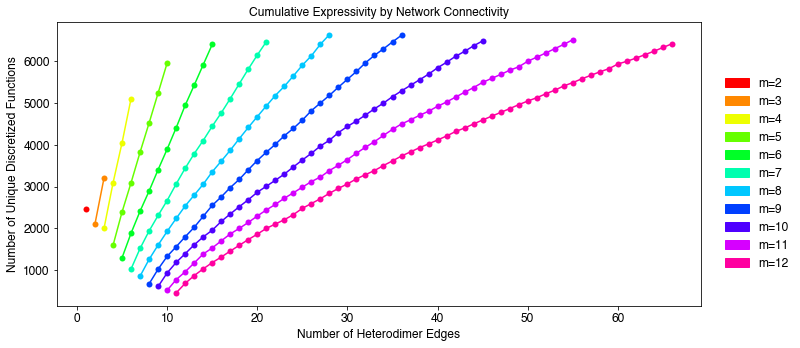

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unique_voxels_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_cumulative_unique_voxels_by_hetero_edges.npy')),allow_pickle=True)
    ax.plot(hetero_edges_list,num_unique_voxels_by_hetero_edges,\
            marker='.',linestyle='-',markersize=12,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Cumulative Expressivity by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_cumulative_voxels_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Count 2-output functions

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze

num_inputs = 2

t = 12 # Number of input points to simulate
input_lb = -3 # Lower bound of input range in log scale
input_ub = 3 # Upper bound of input range in log scale

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_2D','S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_2D','all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_2D','unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_2D','nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_2D','filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
out_dir_temp = str(pathlib.Path(out_dir,'2input, 2output'))

In [ ]:
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    # Load info on dataset
    param_sets = np.load(str(pathlib.Path(load_dir,'param_screen_2D',f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_2D',f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_2D',f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    
    # Create unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel

    num_S_all_chunks = len(S_all_filenames_by_m[m_i])

    # Dataset info
    num_sets = param_sets.shape[0]
    dimers_per_network = num_combos_with_replacement(m,r=2)
    all_curve_idx = np.linspace(0,num_sets*dimers_per_network,num_sets*dimers_per_network,endpoint=False,dtype=np.int64) # Unfiltered IDs. Recall that monomers aren't in this dataset.

    unique_voxel_combos = np.empty((0,)) # Initialize dummy array
    unique_voxels_thism = np.empty((0,)) # Initialize dummy array

    combos_counted = 0
    skipped_networks = 0
    for S_all_chunk in range(num_S_all_chunks):
        print(f"Working on m={m}, chunk {S_all_chunk}")
        curve_idx_in_chunk = all_curve_idx[np.where((all_curve_idx>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                                & (all_curve_idx<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs in chunk
        if curve_idx_in_chunk.shape[0]==0:
            continue
        # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,'param_screen_2D',f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        univ_filter_map_filename = str(pathlib.Path(load_dir,'param_screen_2D',f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
        univ_filter_map = np.load(univ_filter_map_filename,allow_pickle=True)
        unfiltered_curves_previous_chunks = np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])
        curve_idx_in_chunk = (curve_idx_in_chunk-unfiltered_curves_previous_chunks).astype(np.int64) # Unfiltered IDs in chunk, starting at 0 in chunk
        curve_idx_passed_filter = curve_idx_in_chunk[np.isin(curve_idx_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs in chunk, starting at 0 in chunk, that passed filtering
        curve_idx_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_passed_filter)][:,1] # Filtered IDs in chunk, starting at 0 in chunk
        # S_all_subset = S_all_processed_filtered[curve_idx_filtered,:]

        filtered_curves_previous_chunks = np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])
        num_networks_this_chunk = curve_idx_in_chunk.shape[0]//dimers_per_network
        # Initialize array to fill (we won't use all of it)
        voxels = np.zeros((num_combos(dimers_per_network,2)*num_networks_this_chunk,))
        voxel_combos = np.zeros((num_combos(dimers_per_network,2)*num_networks_this_chunk,2))
        previous_unfiltered_curves = 0 # Tracker for which responses we've analyzed
        previous_voxels = 0 # Tracker for which rows we've filled
        previous_combos = 0 # Tracker for which rows we've filled
        for network_i in tqdm(range(num_networks_this_chunk)):
            curve_idx_in_chunk_this_network = curve_idx_in_chunk[previous_unfiltered_curves:previous_unfiltered_curves+dimers_per_network] # monomers aren't in the dataset
            curve_idx_filtered_this_network = curve_idx_filtered[np.where(np.isin(curve_idx_passed_filter,\
                                                                            curve_idx_in_chunk_this_network))]
            previous_unfiltered_curves += dimers_per_network
            voxel_ids_this_network = unique_inverse[(curve_idx_filtered_this_network+filtered_curves_previous_chunks).astype(np.int64)]
            voxels[previous_voxels:previous_voxels+voxel_ids_this_network.shape[0]] = voxel_ids_this_network
            # Skip if no 2-output function possible
            if curve_idx_filtered_this_network.shape[0]<2:
                skipped_networks+=1
                continue
            combos_temp = np.array(list(itertools.combinations(voxel_ids_this_network,2)))
            voxel_combos[previous_combos:previous_combos+combos_temp.shape[0],:] = combos_temp
            previous_voxels += voxel_ids_this_network.shape[0]
            previous_combos += combos_temp.shape[0]
        combos_counted += previous_combos
        # Calculate unique 2-output functions
        voxels = voxels[:previous_voxels] # Keep only the rows we've filled
        voxel_combos = voxel_combos[:previous_combos,:] # Keep only the rows we've filled
        if unique_voxels_thism.shape[0] == 0:
            # if the first, initialize
            unique_voxels_thism = np.unique(voxels,axis=0,return_inverse=False)
        else:
            # if not the first, merge with the existing
            unique_voxels_thism = np.unique(np.concatenate((unique_voxels_thism,voxels),axis=0),axis=0,return_inverse=False)
        if unique_voxel_combos.shape[0] == 0:
            # if the first, initialize
            unique_voxel_combos = np.unique(voxel_combos,axis=0,return_inverse=False)
        else:
            # if not the first, merge with the existing
            unique_voxel_combos = np.unique(np.concatenate((unique_voxel_combos,voxel_combos),axis=0),axis=0,return_inverse=False)
        print(f"{unique_voxels_thism.shape[0]} unique functions")
        print(f"{combos_counted} combos counted, {unique_voxel_combos.shape[0]} unique")
        print(f"{skipped_networks} networks skipped")

        # Save after every chunk just in case
        np.save(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos.npy')),unique_voxel_combos)
        np.save(str(pathlib.Path(out_dir_temp,f'{m}M_combos_counted.npy')),combos_counted)
        np.save(str(pathlib.Path(out_dir_temp,f'{m}M_skipped_networks.npy')),skipped_networks)

        del voxels, voxel_combos, univ_filter_map, curve_idx_in_chunk, curve_idx_passed_filter, curve_idx_filtered

In [ ]:
for m in tqdm(m_list):
    m_i = m_list.index(m)
    # Load info on dataset
    param_sets = np.load(str(pathlib.Path(load_dir,'param_screen_2D',f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_2D',f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_2D',f'{m}M_curves_by_voxel.npy')),allow_pickle=True)

    # Create unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    # Now do the same but for the null hypothesis - just randomly sample curves from the dataset
    rng = np.random.default_rng()
    num_filtered_curves_total = np.sum(filtered_curves_per_Sall_chunk_by_m[m_i])
    # Sample without replacement to avoid pairing the same two curves together, and also because the regular analysis doesn't use replacement
    combos_counted = np.load(str(pathlib.Path(out_dir_temp,f'{m}M_combos_counted.npy')),allow_pickle=True)
    curve_pairs_scrambled = rng.choice(num_filtered_curves_total,size=(combos_counted,2),replace=True) 
    voxel_combos_scrambled = unique_inverse[curve_pairs_scrambled]
    unique_voxel_combos_scrambled = np.unique(voxel_combos_scrambled,axis=0,return_inverse=False)
    print(unique_voxel_combos_scrambled.shape[0])
    # Save
    np.save(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos_scrambled.npy')),unique_voxel_combos_scrambled)

In [ ]:
combos_counted_by_m = []
num_unique_voxels_2output_by_m = []
num_unique_voxels_2output_scrambled_by_m = []
for m_i, m in enumerate(m_list):
    unique_voxel_combos = np.load(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos.npy')),allow_pickle=True)
    unique_voxel_combos_scrambled = np.load(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos_scrambled.npy')),allow_pickle=True)
    combos_counted = int(np.load(str(pathlib.Path(out_dir_temp,f'{m}M_combos_counted.npy')),allow_pickle=True))
    num_unique_voxels_2output_by_m.append(unique_voxel_combos.shape[0])
    num_unique_voxels_2output_scrambled_by_m.append(unique_voxel_combos_scrambled.shape[0])
    combos_counted_by_m.append(combos_counted)

In [ ]:
np.save(str(pathlib.Path(out_dir_temp,f'combos_counted_by_m.npy')),combos_counted_by_m,allow_pickle=True)
np.save(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_by_m.npy')),num_unique_voxels_2output_by_m,allow_pickle=True)
np.save(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_scrambled_by_m.npy')),num_unique_voxels_2output_scrambled_by_m,allow_pickle=True)

### Plot

In [ ]:
combos_counted_by_m = np.load(str(pathlib.Path(out_dir_temp,f'combos_counted_by_m.npy')),allow_pickle=True)
num_unique_voxels_2output_by_m = np.load(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_by_m.npy')),allow_pickle=True)
num_unique_voxels_2output_scrambled_by_m = np.load(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_scrambled_by_m.npy')),allow_pickle=True)

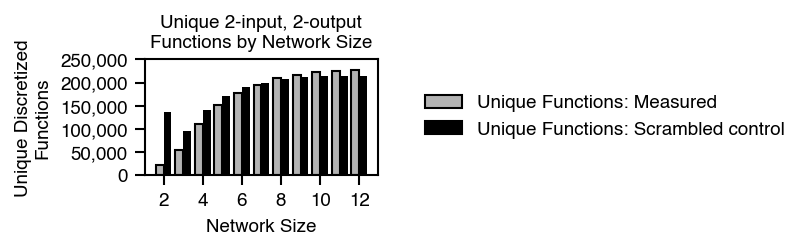

In [ ]:
save = True

fig, ax = plt.subplots(figsize=(2,1))

bar_width  = 0.4
# Real
ax.bar(np.array(m_list)-(bar_width/2),num_unique_voxels_2output_by_m,width=bar_width,facecolor=(0.7,0.7,0.7),edgecolor='k')
# Scrambled
ax.bar(np.array(m_list)+(bar_width/2),num_unique_voxels_2output_scrambled_by_m,width=bar_width,color='k')
# Total
# ax.bar(np.array(m_list),combos_counted_by_m,width=bar_width,color='k')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unique Discretized\nFunctions')
_ = ax.set_title('Unique 2-input, 2-output\nFunctions by Network Size')
_ = ax.set_xticks(np.array(m_list)[::2])
_ = ax.set_xticklabels(np.array(m_list)[::2].astype(str))

# _ = ax.set_yscale('log')
# _ = ax.set_ylim([1,10000])
# _ = ax.set_yticks(np.logspace(0,4,4))
# set_simple_log_ticks(ax,which='y',log_lowerbound=0,log_upperbound=4,max_labels=4)

_ = ax.set_ylim([0,2.5e5])
_ = ax.set_yticks(np.linspace(0,2.5e5,6),labels=[f'{int(x):,}' for x in np.linspace(0,2.5e5,6)])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

# Make legend
patches={}
patches[f'light'] = mpatches.Patch(facecolor=(0.7,0.7,0.7),edgecolor='k',label=f'Unique Functions: Measured')
patches[f'dark'] = mpatches.Patch(facecolor='k',edgecolor='k',label=f'Unique Functions: Scrambled control')
# patches[f'black'] = mpatches.Patch(color='k',edgecolor='none',label=f'All 2-output functions observed')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

# plt.tight_layout()

if save:
    filename = f'FigS3H_num_unique_voxels_1input_2output_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Validation

### How many networks do we need to sample (via bootstrapping)? - Figure S3

Conclusion: We are not saturating our sampling; as we sample more networks, we continue to see more unique functions, but at a log-linear rate. This is likely due to discovering increasingly rare functions.

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
bootstrap_out_dir = str(pathlib.Path(out_dir,'bootstrap'))

if not os.path.isdir(bootstrap_out_dir):
    os.mkdir(bootstrap_out_dir)

In [ ]:
t = 30 # Number of input points to simulate
input_lb = -3 # Lower bound of input range in log scale
input_ub = 3 # Upper bound of input range in log scale

t_voxels = 6 # Number of input regions for calculating unique functions ('voxels')

In [ ]:
# Define voxels
num_regions_per_inputpoint = 6

boundaries = np.logspace(input_lb,input_ub,num_regions_per_inputpoint+1,endpoint=True)[1:-1]

In [ ]:
load_dir = '/home/ubuntu/Data/20230113_2input_randomParamset'

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze

In [ ]:
num_networks_to_test_list = [100, 500, 1000, 2500, 5000, 10000, 15000, 20000, 50000, 100000, 250000,500000,1000000]

num_replicates = 5

In [ ]:
num_networks_bootstrapped = {
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: [],
    12: [],
}

num_unique_voxels_bootstrapped = {
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: [],
    12: [],
}

In [ ]:
for m_i,m in enumerate(m_list):
    specific_out_dir = str(pathlib.Path(bootstrap_out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    # Calculate unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    unfiltered_curves_per_S_all_chunk = all_curves_per_Sall_chunk_by_m[m_i]
    curves_per_param_set = num_combos_with_replacement(m,r=2)

    num_S_all_chunks = len(S_all_filenames_by_m[m_i])
    
    # Iterate over different numbers of networks to test
    for num_networks_to_test in num_networks_to_test_list:
        if num_networks_to_test>param_sets.shape[0]:
            continue
        print(f"Considering {num_networks_to_test} networks, m={m}")
        seed=42
        
        # Adjust number of networks to test such that different connectivities may be sampled evenly
        num_possible_num_edges = num_combos(m,r=2) - (m-1) + 1
        num_sets_per_num_edges = math.ceil(num_networks_to_test/num_possible_num_edges)
        num_sets_per_num_edges_fullset = math.ceil(param_sets.shape[0]/num_possible_num_edges)
        num_networks_to_test = int(num_sets_per_num_edges*num_possible_num_edges)
        num_networks_to_test_fullset = int(num_sets_per_num_edges_fullset*num_possible_num_edges)
        if num_networks_to_test==num_networks_to_test_list[-1]:
            num_replicates_temp = 1
        else:
            num_replicates_temp = num_replicates
        # Iterate over replicates
        for replicate in range(num_replicates_temp):
            # Randomly subset
            rng = np.random.default_rng(seed=seed)
            seed+=1
            param_sets_subset = np.zeros((num_networks_to_test,),dtype=np.int64)
            # Sample parameter sets for each connectivity value
            for num_edges_i,num_edges in enumerate(range(m-1,num_combos(m,r=2)+1)):
                param_sets_subset[num_edges_i*num_sets_per_num_edges:((num_edges_i+1)*num_sets_per_num_edges)] =\
                    rng.choice(np.arange(num_edges_i*num_sets_per_num_edges_fullset,((num_edges_i+1)*num_sets_per_num_edges_fullset)),\
                               num_sets_per_num_edges,replace=False)
            curve_subset = np.array(list(itertools.chain.from_iterable(\
                            [list(range(param_set*curves_per_param_set,(param_set+1)*curves_per_param_set))\
                            for param_set in param_sets_subset]))) # Unfiltered IDs
            # Iterate over chunks of S_all (responses), which were saved separately
            for S_all_chunk in range(num_S_all_chunks):
                curve_subset_in_chunk = curve_subset[np.where((curve_subset>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_subset<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
                if curve_subset_in_chunk.shape[0]==0:
                    continue
                curve_subset_in_chunk = (curve_subset_in_chunk-\
                                            np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
                # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
                univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
                univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
                curve_subset_passed_filter = \
                    curve_subset_in_chunk[np.isin(curve_subset_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
                curve_subset_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_subset_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
                # S_all_subset = S_all_processed_filtered[curve_subset_filtered,:]
                # Knowing the subset of curves, and which voxel each performs, calculate the unique voxels
                if S_all_chunk==0:
                    # If this is the first chunk, initialize unique_voxel_ids
                    unique_voxel_ids = np.unique(unique_inverse[(curve_subset_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                else:
                    # Otherwise, concatenate to unique_voxel_ids
                    unique_voxel_ids_temp = np.unique(unique_inverse[(curve_subset_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                    unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                             axis=0),axis=0,return_inverse=False)
            num_networks_bootstrapped[m].append(num_networks_to_test)
            num_unique_voxels_bootstrapped[m].append(unique_voxel_ids.shape[0])
    
    np.save(str(pathlib.Path(specific_out_dir,f'num_networks_bootstrapped.npy')), num_networks_bootstrapped[m])
    np.save(str(pathlib.Path(specific_out_dir,f'num_unique_voxels_bootstrapped.npy')), num_unique_voxels_bootstrapped[m])
    

    # Plot
    fig, ax = plt.subplots()

    ax.plot(num_networks_bootstrapped[m],num_unique_voxels_bootstrapped[m],ls='', marker='.',ms=12,markeredgewidth=0,color='blueviolet',alpha=0.7)

    unique_num_networks = np.unique(num_networks_bootstrapped[m])
    avg_num_unique_voxels = [np.mean(np.array(num_unique_voxels_bootstrapped[m])\
                                [np.where(np.array(num_networks_bootstrapped[m])==size)])\
                                for size in unique_num_networks]
    ax.plot(unique_num_networks,avg_num_unique_voxels,ls='--', marker='',ms=12,color='k')

    _ = ax.set_xlabel('Number of Networks Sampled')
    _ = ax.set_ylabel('Number of Unique Voxels')
    _ = ax.set_title(f'Bootstrapped networks, m={m}, {num_replicates} replicates')
    fig.patch.set_facecolor('white')

    filename = f'num_unique_voxels_by_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')

    ax.set_xscale('log')
    ax.set_yscale('linear')

    filename = f'num_unique_voxels_by_log_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')

    ax.set_xscale('linear')
    ax.set_yscale('log')

    filename = f'log_num_unique_voxels_by_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')

    ax.set_xscale('log')
    ax.set_yscale('log')

    filename = f'log_num_unique_voxels_by_log_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')
    
    print(f"Finished m={m}.")

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')
for m_i,m in enumerate(m_list):
    specific_out_dir = str(pathlib.Path(bootstrap_out_dir,f'{m}M'))
    num_networks_bootstrapped = np.load(str(pathlib.Path(specific_out_dir,f'num_networks_bootstrapped.npy')), allow_pickle=True)
    num_unique_voxels_bootstrapped = np.load(str(pathlib.Path(specific_out_dir,f'num_unique_voxels_bootstrapped.npy')), allow_pickle=True)
    # ax.plot(num_networks_bootstrapped,num_unique_voxels_bootstrapped,ls='', marker='.',ms=12,markeredgewidth=0,color='blueviolet',alpha=0.7)
    unique_num_networks = np.unique(num_networks_bootstrapped)
    avg_num_unique_voxels = [np.mean(np.array(num_unique_voxels_bootstrapped)\
                                [np.where(np.array(num_networks_bootstrapped)==size)])\
                                for size in unique_num_networks]
    ax.plot(unique_num_networks,avg_num_unique_voxels,ls='-', marker='.',ms=12,lw=2,color=cmap(m_i/len(m_list)))

_ = ax.set_xlabel('Log (Number of Networks Sampled)')
_ = ax.set_ylabel('Log (Number of Unique Voxels)')
_ = ax.set_title(f'Bootstrapped networks, {num_replicates} replicates')
fig.patch.set_facecolor('white')

ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

patches = {}
for m_i, m in enumerate(m_list):
    patches[f'{m}'] = mlines.Line2D([],[],ls='-',color=cmap(m_i/len(m_list)),\
                                            label=f'm={m}')
leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')

filename = f'num_unique_voxels_by_num_networks_all'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')